1. Setup and Data Loading

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
import pickle

# Load the data
coursera_df = pd.read_csv('training_data.csv')
employee_df = coursera_df[['employeeID', 'userSkills', 'points', 'department', 'designation']].drop_duplicates(subset='employeeID')

2. Exploratory Data Analysis (EDA) & Visualizations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8171 entries, 0 to 8170
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employeeID       8171 non-null   object 
 1   courseId         8171 non-null   object 
 2   partner          8171 non-null   object 
 3   course           8171 non-null   object 
 4   expected_skills  8171 non-null   object 
 5   rating           8171 non-null   float64
 6   level            8171 non-null   object 
 7   certificateType  8171 non-null   object 
 8   duration         8171 non-null   object 
 9   designation      8171 non-null   object 
 10  userSkills       8171 non-null   object 
 11  points           8171 non-null   int64  
 12  department       8171 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 830.0+ KB
None
            rating       points
count  8171.000000  8171.000000
mean      4.610880   198.245135
std       0.183887    58.060246
min  

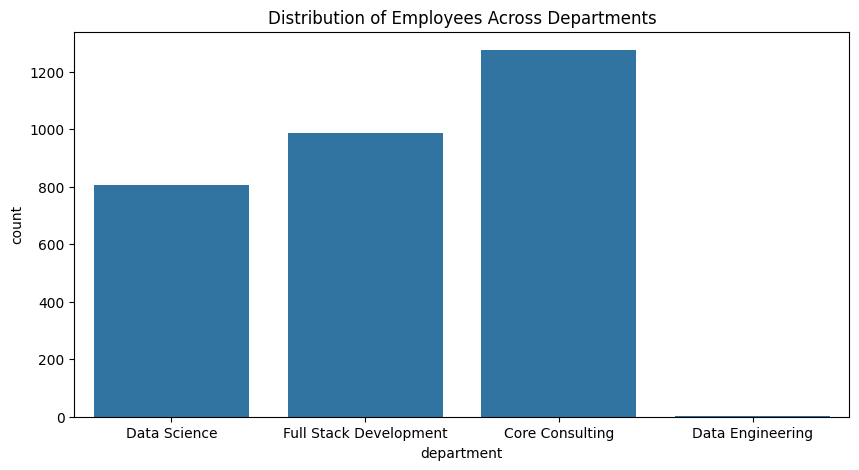

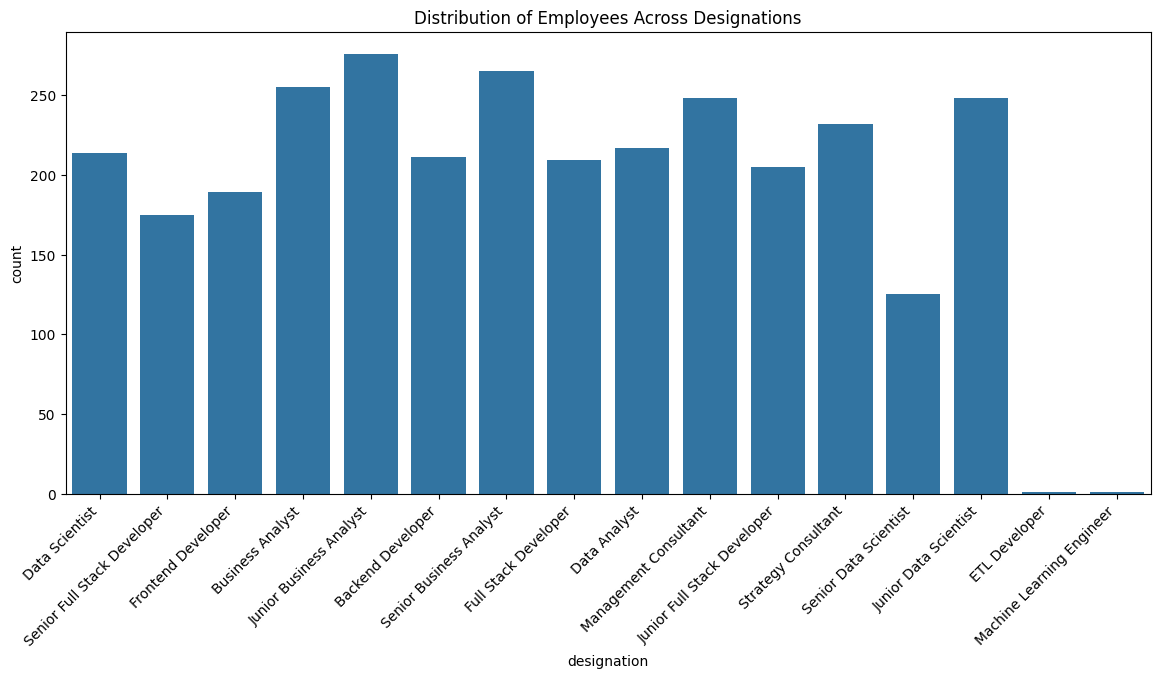

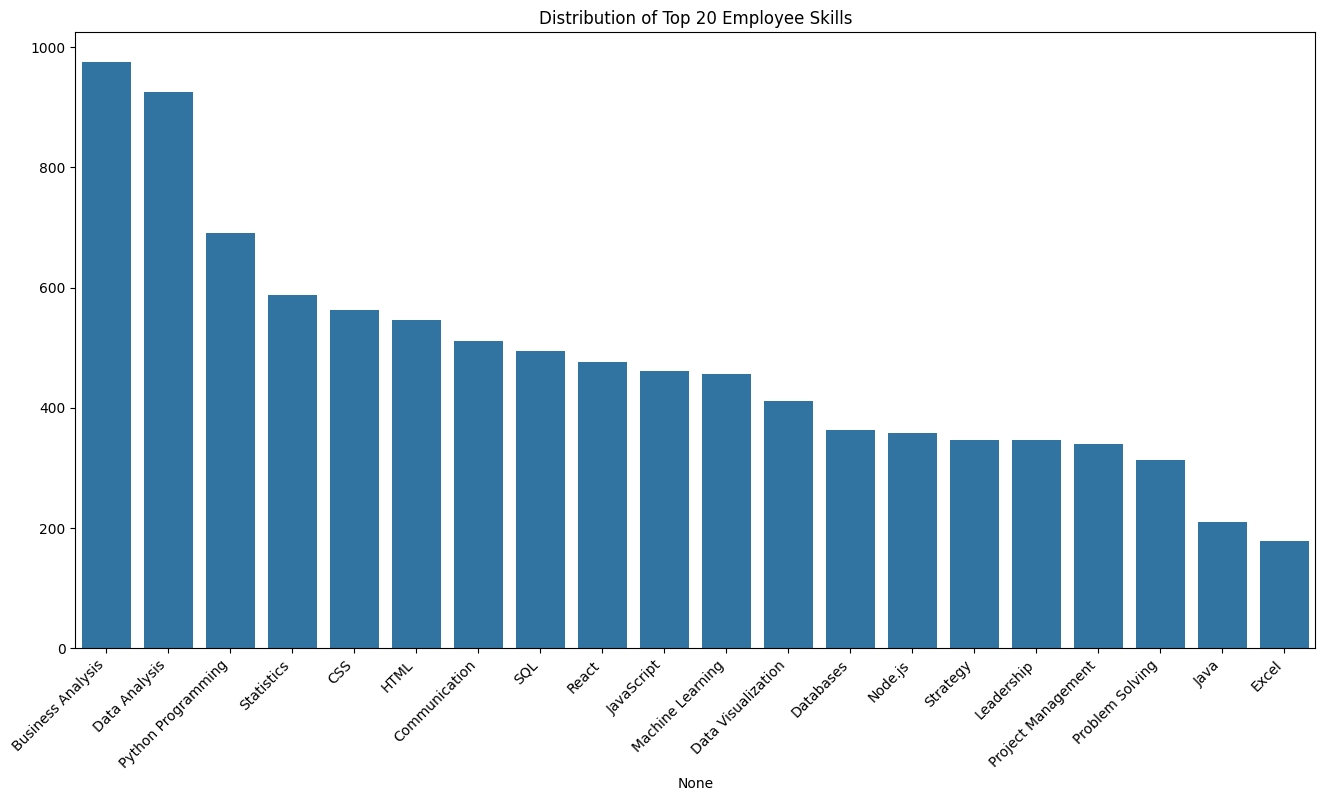

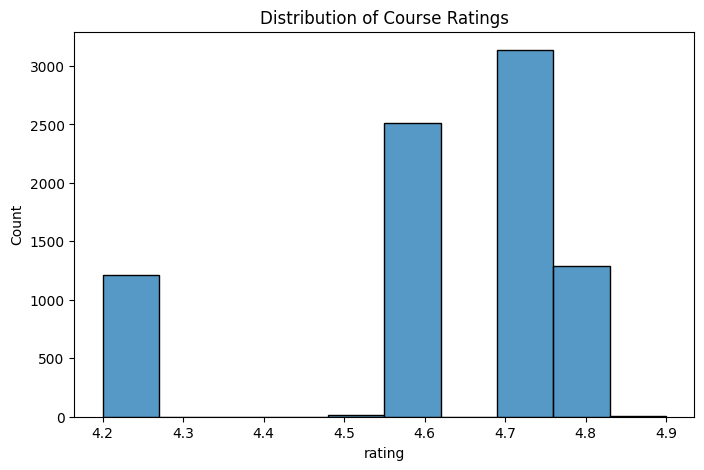

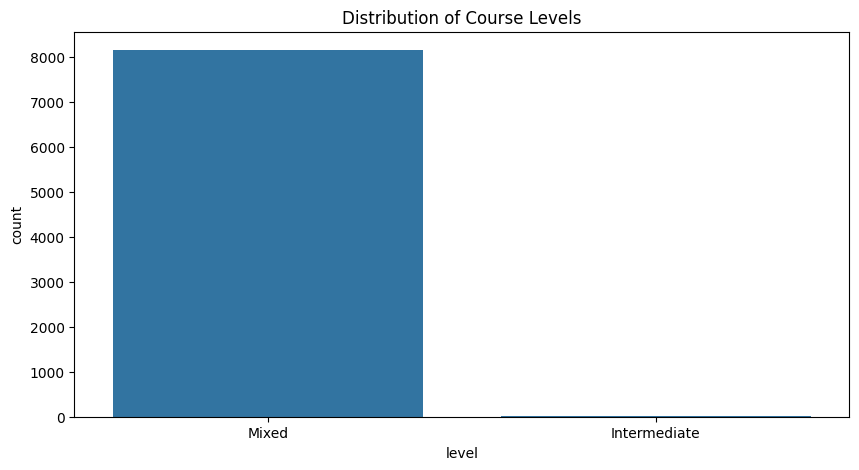

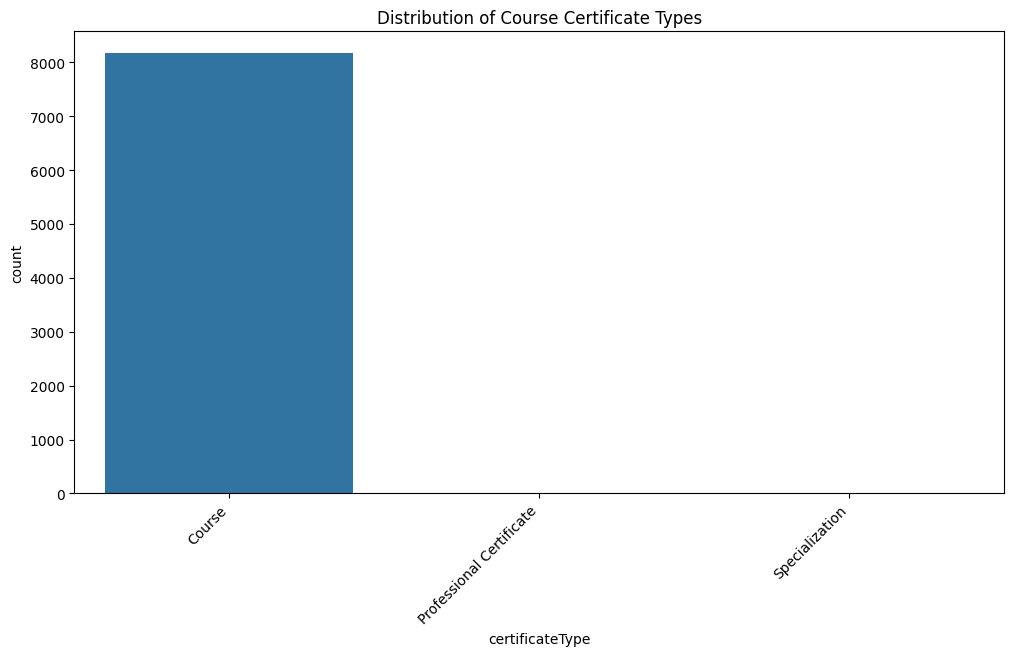

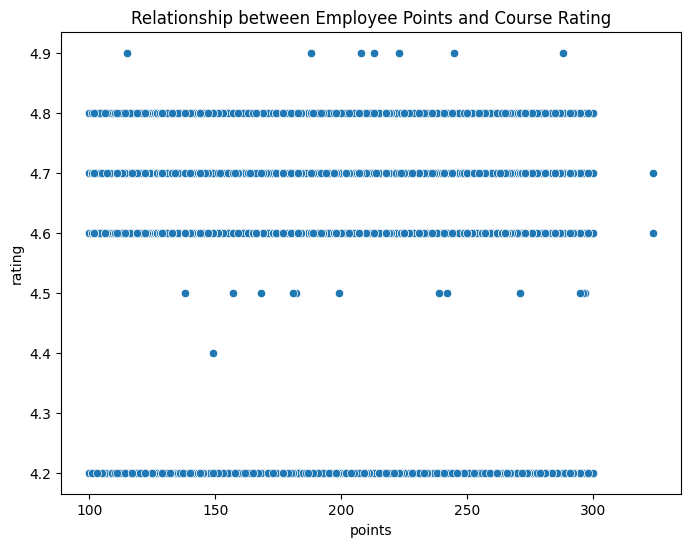

In [87]:
# Basic Information
print(coursera_df.info())
print(coursera_df.describe())
print(employee_df.info())
print(employee_df.describe())

# Distribution of Departments and Designations
plt.figure(figsize=(10, 5))
sns.countplot(x='department', data=employee_df)
plt.title('Distribution of Employees Across Departments')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='designation', data=employee_df)
plt.title('Distribution of Employees Across Designations')
plt.xticks(rotation=45, ha='right')
plt.show()

# Skill Distribution
all_skills = []
for skills_list in employee_df['userSkills']:
    all_skills.extend(eval(skills_list))
skill_counts = pd.Series(all_skills).value_counts()

plt.figure(figsize=(16, 8))
sns.barplot(x=skill_counts.index[:20], y=skill_counts.values[:20])  # Top 20 skills
plt.title('Distribution of Top 20 Employee Skills')
plt.xticks(rotation=45, ha='right')
plt.show()

# Course Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(coursera_df['rating'], bins=10)
plt.title('Distribution of Course Ratings')
plt.show()

# Course Level and Certificate Type Distributions
plt.figure(figsize=(10, 5))
sns.countplot(x='level', data=coursera_df)
plt.title('Distribution of Course Levels')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='certificateType', data=coursera_df)
plt.title('Distribution of Course Certificate Types')
plt.xticks(rotation=45, ha='right')
plt.show()

# Relationship between Points and Rating
plt.figure(figsize=(8, 6))
sns.scatterplot(x='points', y='rating', data=coursera_df)
plt.title('Relationship between Employee Points and Course Rating')
plt.show()

3. Feature Engineering

In [88]:
# --- Feature Engineering ---
# One-Hot Encoding (applied to coursera_df only)
coursera_df = pd.get_dummies(coursera_df, columns=['department', 'designation', 'level', 'certificateType'])

# TF-IDF for Course Embeddings
coursera_df['all_skills'] = coursera_df['expected_skills'].apply(lambda x: ' '.join(eval(x)))
vectorizer = TfidfVectorizer()
course_embeddings = vectorizer.fit_transform(coursera_df['all_skills'])


4.Content-Based Filtering

In [89]:

# --- Content-Based Filtering ---
def content_based_recommendations(employee_skills, course_embeddings, top_n=5):
    """Recommends courses based on skill similarity."""
    employee_skill_vector = [0] * len(vectorizer.vocabulary_)
    for skill in employee_skills:
        if skill in vectorizer.vocabulary_:
            employee_skill_vector[vectorizer.vocabulary_[skill]] = 1

    similarities = cosine_similarity([employee_skill_vector], course_embeddings)
    recommended_course_indices = similarities.argsort()[0][::-1][:top_n]
    return coursera_df.iloc[recommended_course_indices]

5.Collaborative Filtering

In [90]:

# --- Collaborative Filtering ---
# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(coursera_df[['employeeID', 'courseId', 'rating']], reader=reader)

# Use KNNBasic with cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Item-based collaborative filtering (course similarity)
}
algo = KNNBasic(sim_options=sim_options)
filename = 'recommendation_model.pkl'
pickle.dump(algo, open(filename, 'wb'))

# Cross-validation 
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(f"Average RMSE: {cv_results['test_rmse'].mean()}")
print(f"Average MAE: {cv_results['test_mae'].mean()}")

# Train on the entire dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1991  0.2001  0.2058  0.2033  0.2036  0.2024  0.0025  
MAE (testset)     0.1456  0.1470  0.1510  0.1506  0.1489  0.1486  0.0021  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Average RMSE: 0.20236543166019483
Average MAE: 0.14862204814440522
Computing the cosine similarity matrix...
Done computing similarity matrix.


6.Hybrid Recommendation System

In [91]:

# --- Hybrid Recommendations ---
def hybrid_recommendations(employee_id, top_n=5, content_weight=0): # Change top_n to 5
    """Combines content-based and collaborative filtering with weighting."""
    employee_data = employee_df[employee_df['employeeID'] == employee_id]
    if employee_data.empty:
        print(f"Warning: No employee data found for ID: {employee_id}")
        return pd.DataFrame()

    employee_skills = eval(employee_data['userSkills'].iloc[0])
    # ... (Print employee information - keep this part)

    content_recs = content_based_recommendations(employee_skills, course_embeddings, top_n=top_n * 5)  # Get more content-based recs 
    content_indices = content_recs.index.tolist()

    collab_recs = []
    for course_id in coursera_df['courseId'].unique():
        prediction = algo.predict(employee_id, course_id)
        collab_recs.append((course_id, prediction.est))
    collab_recs.sort(key=lambda x: x[1], reverse=True)
    collab_recs = collab_recs[:top_n]
    collab_indices = [coursera_df[coursera_df['courseId'] == rec[0]].index[0] for rec in collab_recs]

    # --- Weighted Hybrid Recommendation Logic --- 
    final_recs = []
    for i in range(top_n):
        if i < int(top_n * content_weight) and content_indices:
            final_recs.append(coursera_df.iloc[content_indices.pop(0)])  
        elif collab_indices:
            final_recs.append(coursera_df.iloc[collab_indices.pop(0)]) 

    final_recs_df = pd.DataFrame(final_recs) # Create dataframe from final recommendations
    print("Recommended Courses:\n", final_recs_df[['course', 'expected_skills', 'rating', 'level_Intermediate', 'level_Mixed']])
    return final_recs_df

Sample Usage

In [92]:
recommendations = hybrid_recommendations('EMP172793995133113') 

Recommended Courses:
                                               course  \
0            Introduction to Spreadsheets and Models   
2         HTML CSS and Javascript for Web Developers   
4  The Manager's Toolkit: A Practical Guide to Ma...   
5                          Human Resources Analytics   
6                         Food & Beverage Management   

                                     expected_skills  rating  \
0  {" Data Analysis"," Forecasting"," General Sta...     4.2   
2  {" Front-End Web Development"," HTML and CSS",...     4.7   
4  {" Human Resources"," Leadership and Managemen...     4.7   
5  {" Human Resources"," People Analysis"," Busin...     4.6   
6  {" Design and Product"," Marketing"," Business...     4.8   

   level_Intermediate  level_Mixed  
0               False         True  
2               False         True  
4               False         True  
5               False         True  
6               False         True  
